In [110]:
import glob
import pandas as pd
import numpy as np
import sklearn as sk
import datetime as dt
import matplotlib.pyplot as plt

In [111]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.utils import shuffle

In [38]:
# Read filenames, excluding label file. Sort so that single digits appear first.
filenames = glob.glob('*.dat')
filenames = filenames[:-1]

for i in range(len(filenames)):
    if len(filenames[i]) == 13:
        filenames[i] = filenames[i][:8] + '0' + filenames[i][8:]

filenames.sort()

for i in range(9):
    filenames[i] = filenames[i][:8] + filenames[i][9:]
    
print(filenames)

['channel_1.dat', 'channel_2.dat', 'channel_3.dat', 'channel_4.dat', 'channel_5.dat', 'channel_6.dat', 'channel_7.dat', 'channel_8.dat', 'channel_9.dat', 'channel_10.dat', 'channel_11.dat', 'channel_12.dat', 'channel_13.dat', 'channel_14.dat', 'channel_15.dat', 'channel_16.dat', 'channel_17.dat', 'channel_18.dat', 'channel_19.dat', 'channel_20.dat']


In [39]:
# Extract list of labels from file
df_labels = pd.read_csv('labels.dat', names = ['Labels'])
labels = df_labels['Labels'].tolist()

for i in range(9):
    labels[i] = '0' + labels[i]

print(labels)

['01 mains', '02 mains', '03 oven', '04 oven', '05 refrigerator', '06 dishwasher', '07 kitchen_outlets', '08 kitchen_outlets', '09 lighting', '10 washer_dryer', '11 microwave', '12 bathroom_gfi', '13 electric_heat', '14 stove', '15 kitchen_outlets', '16 kitchen_outlets', '17 lighting', '18 lighting', '19 washer_dryer', '20 washer_dryer']


In [40]:
# Create list of all channels with date and power labelled
column_names = ['Date','Power']
df_all_list = [pd.read_csv(file,sep = ' ',names = column_names) for file in filenames]

# Create dictionary of labels and their corresponding dataframes
df_dict = dict(zip(labels,df_all_list))

# View shape of each dataframe
for key in df_dict:
    print(key, df_dict[key].shape)

01 mains (1561660, 2)
02 mains (1561660, 2)
03 oven (745878, 2)
04 oven (745878, 2)
05 refrigerator (745878, 2)
06 dishwasher (745878, 2)
07 kitchen_outlets (745878, 2)
08 kitchen_outlets (745878, 2)
09 lighting (745878, 2)
10 washer_dryer (745878, 2)
11 microwave (745878, 2)
12 bathroom_gfi (745878, 2)
13 electric_heat (745878, 2)
14 stove (745878, 2)
15 kitchen_outlets (745878, 2)
16 kitchen_outlets (745878, 2)
17 lighting (745878, 2)
18 lighting (745878, 2)
19 washer_dryer (745878, 2)
20 washer_dryer (745878, 2)


In [41]:
for key in df_dict:
    
    # Convert integer dates to datetime and set as index
    df_dict[key]['Date'] = pd.to_datetime(df_dict[key]['Date'],unit = 's')
    df_dict[key] = df_dict[key].set_index(['Date'])
    
    # Relabel Power column as the source label
    df_dict[key].columns = [key]

In [164]:
# Create dataframe of mains signals
df_mains = pd.concat([df_dict[label] for label in labels[:2]], axis = 1)

# Create dataframe of other channel signals
df_channels = pd.concat([df_dict[label] for label in labels[2:]], axis = 1)

# Create dataframe with everything using inner join (only keep rows where index appears in all frames)
df_total = pd.concat([df_mains, df_channels], axis = 1, join = 'inner')

In [165]:
# Create total mains column and sort so that it appears first
df_total['00 mains total'] = df_total['01 mains'] + df_total['02 mains']
df_total = df_total.drop(['01 mains', '02 mains'], axis = 1)
df_total = df_total.sort_index(axis=1)

In [166]:
# Calculate fraction of total energy for each source, and only keep those contributing > 5%
frac_total_energy = df_total.sum() / df_total['00 mains total'].sum()
print(frac_total_energy)
frac_total_energy = frac_total_energy > 0.03
df_total = df_total[df_total.columns[frac_total_energy]]

00 mains total        1.000000e+00
03 oven               1.618362e-02
04 oven               2.018825e-02
05 refrigerator       1.447317e-01
06 dishwasher         6.497505e-02
07 kitchen_outlets    5.537610e-02
08 kitchen_outlets    7.387586e-02
09 lighting           1.129090e-01
10 washer_dryer       1.020206e-02
11 microwave          5.804437e-02
12 bathroom_gfi       1.824984e-02
13 electric_heat      3.327021e-04
14 stove              3.000005e-04
15 kitchen_outlets    1.434670e-02
16 kitchen_outlets    5.289653e-03
17 lighting           4.704700e-02
18 lighting           3.469935e-02
19 washer_dryer       2.083515e-07
20 washer_dryer       8.306274e-02
dtype: float64


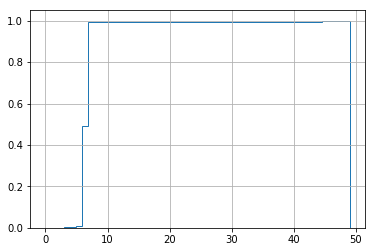

In [151]:
df_total['05 refrigerator'][(df_total['05 refrigerator'] < 50)].hist(cumulative=True, normed=1, bins=100, histtype='step')
plt.show()

In [170]:
df_io = df_total.copy()
df_io.iloc[:,1:] = df_io.iloc[:,1:] > 0
df_io.iloc[:,1:] = df_io.iloc[:,1:].astype(int)

print(df_io.sum())
print(df_io.shape)

00 mains total        155986400.8
05 refrigerator          406712.0
06 dishwasher             37033.0
07 kitchen_outlets       406748.0
08 kitchen_outlets       406748.0
09 lighting              382361.0
11 microwave             406748.0
17 lighting              111425.0
18 lighting              405221.0
20 washer_dryer            5058.0
dtype: float64
(406748, 10)


In [172]:
# Note kitchen outlets and microwave are "always on" and will not work in classification so we need to drop.
df_io = df_io.drop(['07 kitchen_outlets', '08 kitchen_outlets', '11 microwave'], axis = 1)

In [173]:
# Create time series column t
df_io['t'] = df_io['00 mains total'].copy()

# Create shifted time series columns t-1 to t-9
for i in range(1,10):
    df_io['t-' + str(i)] = df_io['00 mains total'].shift(i)

# Drop original mains column    
df_io = df_io.drop(['00 mains total'], axis = 1)

# Drop NaNs
df_io = df_io.dropna(how = 'any')

In [183]:
# Create X and Y sets for multilabel classification
Y_all = df_io.iloc[:,:6]
X = df_io.iloc[:,6:]

In [184]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train_all, Y_test_all = train_test_split(X, Y_all, test_size=0.2, random_state=100)

In [191]:
# Add logistic regression object
logreg = LogisticRegression()

# Create dataframe of metrics
metrics = ['accuracy','precision','recall','f1 score', 'hamming loss']
appliances = Y_all.columns.tolist()
blank_data = np.zeros((len(metrics),len(appliances)))
df_metrics = pd.DataFrame(data = blank_data, columns = appliances, index = metrics)

# Create dictionary of metrics and sklearn metric objects
metric_objects = [sk.metrics.accuracy_score,
                  sk.metrics.precision_score,
                  sk.metrics.recall_score,
                  sk.metrics.f1_score,
                  sk.metrics.hamming_loss]

metric_dict = dict(zip(metrics, metric_objects))

In [186]:
Y_train_all.columns

Index(['05 refrigerator', '06 dishwasher', '09 lighting', '17 lighting',
       '18 lighting', '20 washer_dryer'],
      dtype='object')

In [187]:
Y_train_all = Y_train_all.reset_index(drop = True)

In [188]:
for col in Y_train_all.columns:
    
    # Relabel so only one appliance is trained on
    Y_train = Y_train_all[col]
    Y_test = Y_test_all[col]
    
    # Fit data
    logreg.fit(X_train, Y_train)
    
    # Predict Y values
    Y_pred = logreg.predict(X_test)
    
    for metric in metrics:
        df_metrics.loc[metric, col] = metric_dict[metric](Y_test, Y_pred)

In [189]:
df_metrics

,05 refrigerator,06 dishwasher,09 lighting,17 lighting,18 lighting,20 washer_dryer
accuracy,0.999877,0.909156,0.941511,0.738260,0.996103,0.986834
precision,0.999889,0.432749,0.941533,0.731751,0.996581,0.407534
recall,0.999988,0.010045,0.999974,0.073185,0.999519,0.117011
f1 score,0.999939,0.019634,0.969874,0.133062,0.998048,0.181818
hamming loss,0.000123,0.090844,0.058489,0.261740,0.003897,0.013166


In [190]:
knn = KNeighborsClassifier(n_neighbors = 3)

In [192]:
df_metrics_knn = pd.DataFrame(data = blank_data, columns = appliances, index = metrics)

In [195]:
for col in Y_train_all.columns:
    
    # Relabel so only one appliance is trained on
    Y_train = Y_train_all[col]
    Y_test = Y_test_all[col]
    
    # Fit data
    knn.fit(X_train, Y_train)
    
    # Predict Y values
    Y_pred = knn.predict(X_test)
    
    for metric in metrics:
        df_metrics_knn.loc[metric, col] = metric_dict[metric](Y_test, Y_pred)

In [196]:
df_metrics_knn

,05 refrigerator,06 dishwasher,09 lighting,17 lighting,18 lighting,20 washer_dryer
accuracy,0.999877,0.935401,0.956791,0.910041,0.996841,0.998795
precision,0.999889,0.670433,0.967393,0.868030,0.998347,0.964611
recall,0.999988,0.563866,0.987388,0.792762,0.998483,0.938053
f1 score,0.999939,0.612549,0.977288,0.828690,0.998415,0.951147
hamming loss,0.000123,0.064599,0.043209,0.089959,0.003159,0.001205


In [197]:
nb = GaussianNB()

In [198]:
df_metrics_nb = pd.DataFrame(data = blank_data, columns = appliances, index = metrics)

In [199]:
for col in Y_train_all.columns:
    
    # Relabel so only one appliance is trained on
    Y_train = Y_train_all[col]
    Y_test = Y_test_all[col]
    
    # Fit data
    nb.fit(X_train, Y_train)
    
    # Predict Y values
    Y_pred = nb.predict(X_test)
    
    for metric in metrics:
        df_metrics_nb.loc[metric, col] = metric_dict[metric](Y_test, Y_pred)

In [200]:
df_metrics_nb

,05 refrigerator,06 dishwasher,09 lighting,17 lighting,18 lighting,20 washer_dryer
accuracy,0.982495,0.904398,0.910225,0.747689,0.984056,0.980626
precision,1.000000,0.453154,0.942531,0.684480,0.999937,0.390778
recall,0.982493,0.269173,0.963390,0.149729,0.984061,0.983284
f1 score,0.991169,0.337733,0.952846,0.245709,0.991936,0.559284
hamming loss,0.017505,0.095602,0.089775,0.252311,0.015944,0.019374


In [201]:
rfc = RandomForestClassifier()

In [202]:
df_metrics_rfc = pd.DataFrame(data = blank_data, columns = appliances, index = metrics)

In [203]:
for col in Y_train_all.columns:
    
    # Relabel so only one appliance is trained on
    Y_train = Y_train_all[col]
    Y_test = Y_test_all[col]
    
    # Fit data
    rfc.fit(X_train, Y_train)
    
    # Predict Y values
    Y_pred = rfc.predict(X_test)
    
    for metric in metrics:
        df_metrics_rfc.loc[metric, col] = metric_dict[metric](Y_test, Y_pred)

In [204]:
df_metrics_rfc

,05 refrigerator,06 dishwasher,09 lighting,17 lighting,18 lighting,20 washer_dryer
accuracy,0.999889,0.945862,0.963945,0.922641,0.997406,0.999127
precision,0.999889,0.816898,0.969279,0.882089,0.998483,0.979716
recall,1.000000,0.518393,0.993185,0.828951,0.998914,0.949853
f1 score,0.999945,0.634280,0.981086,0.854695,0.998699,0.964553
hamming loss,0.000111,0.054138,0.036055,0.077359,0.002594,0.000873


In [205]:
abc = AdaBoostClassifier()

In [206]:
df_metrics_abc = pd.DataFrame(data = blank_data, columns = appliances, index = metrics)

In [207]:
for col in Y_train_all.columns:
    
    # Relabel so only one appliance is trained on
    Y_train = Y_train_all[col]
    Y_test = Y_test_all[col]
    
    # Fit data
    abc.fit(X_train, Y_train)
    
    # Predict Y values
    Y_pred = abc.predict(X_test)
    
    for metric in metrics:
        df_metrics_abc.loc[metric, col] = metric_dict[metric](Y_test, Y_pred)

In [208]:
df_metrics_abc

,05 refrigerator,06 dishwasher,09 lighting,17 lighting,18 lighting,20 washer_dryer
accuracy,0.999914,0.925112,0.958389,0.882579,0.997074,0.998758
precision,0.999926,0.800566,0.959433,0.770599,0.997403,0.973140
recall,0.999988,0.230487,0.998002,0.814709,0.999667,0.926254
f1 score,0.999957,0.357926,0.978338,0.792040,0.998534,0.949118
hamming loss,0.000086,0.074888,0.041611,0.117421,0.002926,0.001242
